# Convolutional Variational Autoencoder

**Dataset**: MNIST Dataset from Keras API

**Reference**: [Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

A VAE is a `probabilistic` take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a `probability distribution`, such as the `mean` and `variance` of a `Gaussian`. This approach produces a continuous, structured latent space, which is useful for image generation.



![](https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg)

In [1]:
# import the necessary packages
import imageio
import glob
import os
import time
import cv2
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

%matplotlib inline

In [2]:
experiment = {
    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),

    'ACCELERATOR': 'GPU',  # Or 'TPU'

    'BACKBONE': 'custom', # Or 'custom' TODO: Add ResNet model
    'BATCH_SIZE': 128,
    'EPOCHS': 50,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0005,  # 1e-4
    'RECONS_LOSS': 'MSE',     # reconstruction loss ('SSIM', 'MSE', 'MAE')
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'SAVE_WEIGHTS_PER_EPOCH': 10,

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 200,

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/cartoon/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/cartoon/images",
}

### VAE Implementation

* Create Model including Encoder and Decoder models
* Use Reparameterization trick for mapping
* KL divergence loss
* Reconstruction loss
* Sampling

### Load and Preprocess Data

Insert kaggle.json file into project workspace ('/content')

In [3]:
! pip install -q kaggle

#from google.colab import files
# files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paulrohan2020/cartoonset100k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cartoonset100k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
CARTOON_DS_PATH_ZIP = '/content/cartoonset100k.zip'

In [5]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
unzip_data(CARTOON_DS_PATH_ZIP)

In [7]:
CARTOON_DS_PATH = '/content/cartoonset100k/'

Print working or data directory map - walk through directory

In [8]:
import os

def walk_through_dir(data_dir):
  for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [9]:
walk_through_dir(CARTOON_DS_PATH)

There are 10 directories and 0 images in '/content/cartoonset100k/'.
There are 0 directories and 20000 images in '/content/cartoonset100k/5'.
There are 0 directories and 20000 images in '/content/cartoonset100k/2'.
There are 0 directories and 20000 images in '/content/cartoonset100k/9'.
There are 0 directories and 20000 images in '/content/cartoonset100k/4'.
There are 0 directories and 20000 images in '/content/cartoonset100k/3'.
There are 0 directories and 20000 images in '/content/cartoonset100k/0'.
There are 0 directories and 20000 images in '/content/cartoonset100k/8'.
There are 0 directories and 20000 images in '/content/cartoonset100k/6'.
There are 0 directories and 20000 images in '/content/cartoonset100k/1'.
There are 0 directories and 20000 images in '/content/cartoonset100k/7'.


In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  CARTOON_DS_PATH,
  image_size=experiment['IMAGE_SIZE'],
  batch_size=experiment['BATCH_SIZE'],
  label_mode=None)

Found 100000 files belonging to 1 classes.


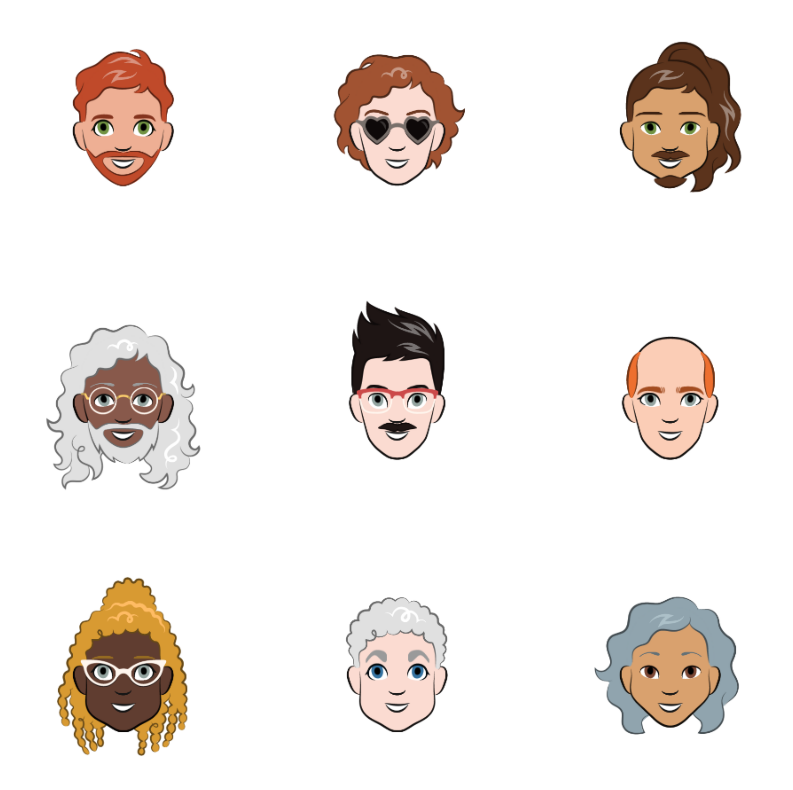

In [11]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Normalization Layer (Rescaling)

In [12]:
from tensorflow.keras import layers, Model

normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
normalized_train_dataset = train_ds.map(lambda x: normalization_layer(x))

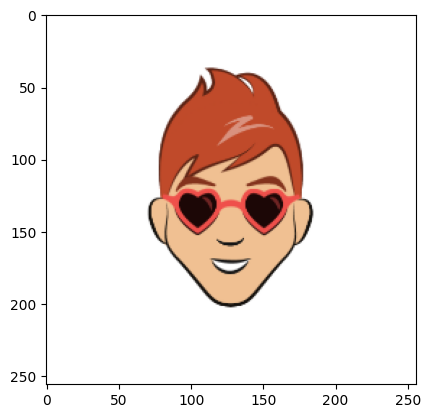

In [13]:
image_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]
plt.imshow(first_image)

In [14]:
print(np.min(first_image), np.max(first_image))

0.023529414 1.0


### Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a `diagonal Gaussian`, and the network outputs the `mean` and `log-variance` parameters of a factorized Gaussian. Output `log-variance` instead of the variance directly for numerical stability.

In [15]:
def create_encoder_model(input_encoder, latent_dim):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)

    # Final Block
    flatten = layers.Flatten()(x)  # (None, 7, 7, 64) to (None, 3136)

    # Latent variables
    mean = layers.Dense(latent_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_dim, name='log_var')(flatten)
    # Model
    model = Model(inputs, (mean, log_var), name="Encoder")

    model.summary()
    keras.utils.plot_model(model, "encoder_model.png")
    return model

### Decoder network

This defines the conditional distribution of the observation p(x|z), which takes a latent sample as input and outputs the parameters for a conditional distribution of the observation. Model the latent distribution prior p(z) as a unit Gaussian.

In [16]:
def create_decoder_model(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8, 8, 64), name='Reshape_Layer')(x)

    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")

    model.summary()
    keras.utils.plot_model(model, "decoder_model.png")
    return model

### The Sampling Network

In [17]:
def sampling(input_mean, input_logvar):
    mean = keras.Input(shape=input_mean, name='input_mean')
    log_var = keras.Input(shape=input_logvar, name='input_logvar')

    out = layers.Lambda(sampling_reparameterization_model, name='encoder_output')([mean, log_var])
    enc_2 = keras.Model([mean, log_var], out,  name="Encoder_2")

    enc_2.summary()
    keras.utils.plot_model(enc_2, "sampling_model.png")
    return enc_2

### Reparameterization trick

To generate a sample `z` for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation `x`. However, this sampling operation creates a bottleneck because `backpropagation cannot flow through a random node`. To address this issue, we use a `reparameterization trick`.

![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-1024x479.jpg)

![](https://mlarchive.com/wp-content/uploads/2022/10/Screen-Shot-2022-10-08-at-1.59.49-PM-1-768x225.png)

Generate epsilon from standard normal distribution. The latent variable z is now generated by a function of mean, variance and epsilon, which would enable the model to backpropagate gradients in the encoder through mean and variance respectively, while maintaining stochasticity through epsilon.

In [18]:
from keras import backend as K

def sampling_reparameterization_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    z = mean + K.exp(log_var / 2) * epsilon   # z = μ + ε*log(σ)*0.5
    return z

### Loss Functions and Optimizer

![](https://miro.medium.com/v2/resize:fit:720/0*jhi0jGQl9rZoqOvI)

### Optimizer

In [19]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = experiment['LEARNING_RATE'])

In [20]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

In [21]:
def mae_loss(y_true, y_pred):
    r_loss = K.mean(K.abs(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

In [22]:
def kl_loss(mean, log_var):
    kl_loss_result =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_result

In [23]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [24]:
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_result = kl_loss(mean, log_var)
    return  r_loss + kl_loss_result

### Training the Model

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of `mean` and `log-variance` parameters of the approximate posterior `q(z|x)` then apply the reparameterization trick to sample from `q(z|x)`
* Pass the `reparameterized samples` to the decoder to obtain the logits of the generative distribution `p(x|z)`

### Get Encoder and Decoder Models

In [25]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'] , experiment['LATENT_DIM'])
decoder_model = create_decoder_model(experiment['LATENT_DIM'])

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 128, 128, 32)         896       ['input_layer[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)   (None, 128, 128, 32)         128       ['conv_1[0][0]']              
                                                                                                  
 lrelu_1 (LeakyReLU)         (None, 128, 128, 32)         0         ['bn_1[0][0]']                
                                                                                            

In [26]:
input_mean = (experiment['LATENT_DIM'],)
input_logvar = (experiment['LATENT_DIM'],)

In [27]:
sampling_model = sampling(input_mean, input_logvar)

Model: "Encoder_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mean (InputLayer)     [(None, 200)]                0         []                            
                                                                                                  
 input_logvar (InputLayer)   [(None, 200)]                0         []                            
                                                                                                  
 encoder_output (Lambda)     (None, 200)                  0         ['input_mean[0][0]',          
                                                                     'input_logvar[0][0]']        
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = encoder_model(images, training=True)
        latent = sampling_model([mean, log_var])   # Reparametrization
        generated_images = decoder_model(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

    gradients_of_enc = encoder.gradient(loss, encoder_model.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, decoder_model.trainable_variables)

    optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))
    return loss

In [29]:
def train(dataset, epochs):
    loss_hist = []  # Keep loss history
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            loss = train_step(image_batch)

        loss_hist.append(loss)   # Add loss value to the loss history after each epoch
        print("loss: ", loss)
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([encoder_model, sampling_model, decoder_model],
                                  epoch + 1,
                                  seed)

        # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
        if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
          encoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/encoder_model_'+ str(epoch)+'.h5')
          decoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/decoder_model_'+ str(epoch)+'.h5')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([encoder_model, sampling_model, decoder_model],
                            epochs,
                            seed)
    return loss_hist

In [30]:
os.makedirs(experiment['TRAINING_WEIGHT_DIR'], exist_ok=True)
os.makedirs(experiment['IMGS_DIR'], exist_ok=True)

### Generating Images

In [31]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  mean, var = encoder_model(test_input, training=False)
  latent = sampling_model([mean,  var])
  predictions = decoder_model(latent, training=False)

  print("test_input.shape: ", test_input.shape)
  print("mean.shape: ", mean.shape)
  print("var.shape: ", var.shape)
  print("latent.shape: ", latent.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')

  plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

20000 images too large to train. Take the first 200 batches only. (100*128 = 12800)

In [32]:
normalized_train_dataset_part = normalized_train_dataset.take(100)

In [33]:
# Use trained weights
# cvae_model_hist = train(normalized_train_dataset_part.take(100), experiment['EPOCHS'])

### Plot Loss Curve

In [34]:
# Use trained weights
# plt.plot(cvae_model_hist)

### Load weights from Google Drive

In [35]:
TRAINING_WEIGHT_DIR = '.../tf_vae/training_weights'

# Load weigths that generated with last epoch
encoder_model.load_weights(TRAINING_WEIGHT_DIR + '/encoder_model_'
                           + str(experiment['EPOCHS'] - 1) + '.h5')
decoder_model.load_weights(TRAINING_WEIGHT_DIR + '/decoder_model_'
                           + str(experiment['EPOCHS'] - 1) + '.h5')

### Load weights from Local workspace

In [36]:
# Load weigths that generated with last epoch
# encoder_model.load_weights(experiment['TRAINING_WEIGHT_DIR'] + '/encoder_model_'
#                            + str(experiment['EPOCHS'] - 1) + '.h5')
# decoder_model.load_weights(experiment['TRAINING_WEIGHT_DIR'] + '/decoder_model_'
#                            + str(experiment['EPOCHS'] - 1) + '.h5')

In [37]:
def get_model_embeddings(embeddings=None, mean=None, var=None, model='sampling'):
    for i in normalized_train_dataset_part:
        m,v = encoder_model.predict(i)
        latent = sampling_model.predict([m,v])
        if not (model == 'sampling' or model == 'decoder'):
            raise ValueError("Valid model types= 'sampling' and 'decoder'")

        if model == 'sampling':
          embed = latent
        else:
          embed = decoder_model.predict(latent)

        if embeddings is None:
            embeddings = embed
            mean = m
            var = v
        else:
            embeddings = np.concatenate((embeddings, embed))
            mean = np.concatenate((mean, m))
            var = np.concatenate((var, v))

        if embeddings.shape[0] > 5000:
            break

    return embeddings

In [38]:
embeddings = get_model_embeddings(model='sampling')
# embeddings = get_model_embeddings(model='decoder')
embeddings.shape

4/4 [==============================] - 0s 4ms/step


(5120, 200)

### Latent Space Projection with t-SNE of VAE Trained on Cartoon Set

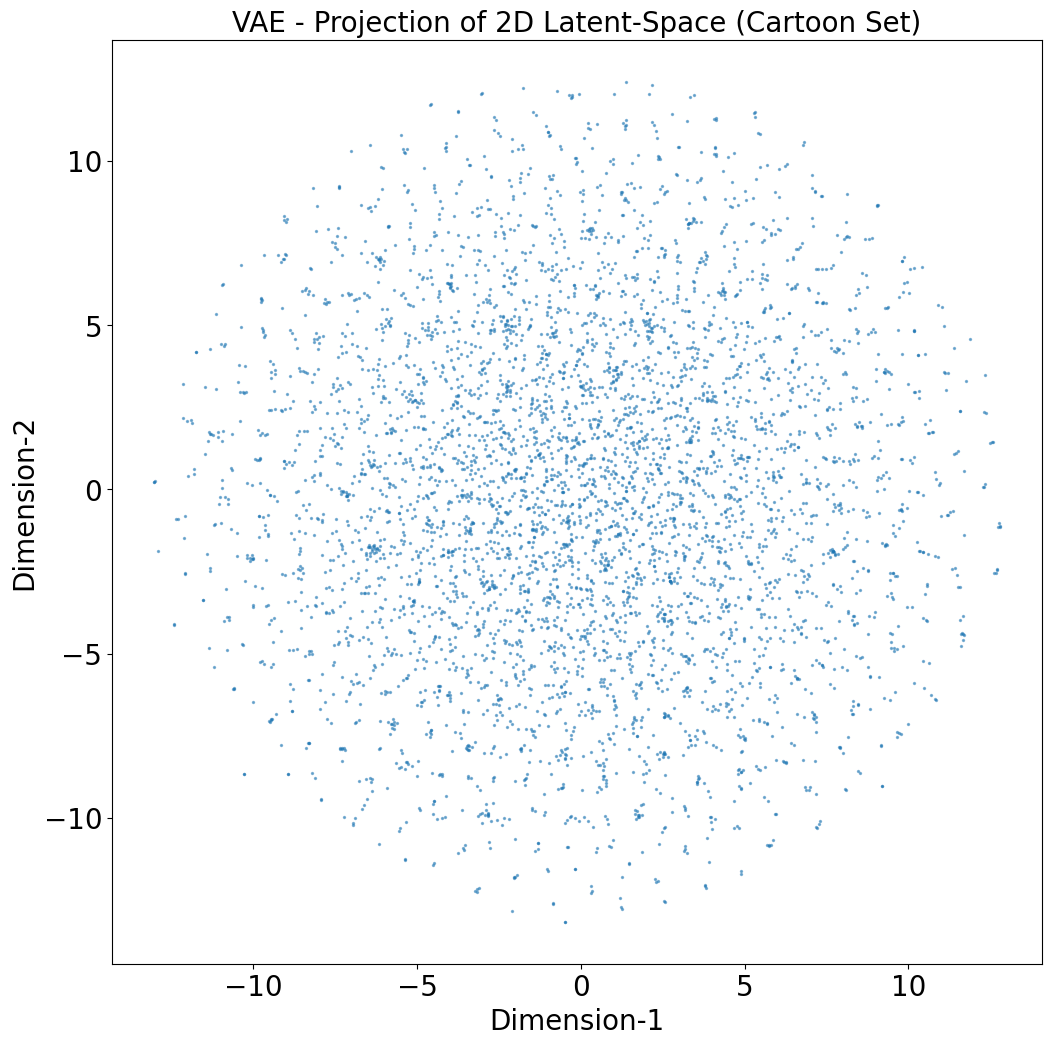

In [39]:
from sklearn.manifold import TSNE

n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)

min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("VAE - Projection of 2D Latent-Space (Cartoon Set)", size=20)
plt.show()

### Reconstructing Test Images

In [47]:
def get_generated_image_batch(data, model='decoder'):
    reconstructed_batch = None
    latent_space = None

    if not (model == 'sampling' or model == 'decoder'):
        raise ValueError("Valid model types= 'sampling' and 'decoder'")

    for image_batch in data:
      mean, log_var = encoder_model.predict(image_batch)
      latent_vector = sampling_model([mean,log_var])
      generated_batch = decoder_model.predict(latent_vector)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
          latent_space = latent_vector
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))
          latent_space = np.concatenate((latent_space, latent_vector))

      if reconstructed_batch.shape[0] > 5000:
          break

    if model == 'sampling':  return latent_space
    else: return reconstructed_batch

In [42]:
reconstructed_batch = get_generated_image_batch(normalized_train_dataset_part.take(1))  # Use only first batch (128 images))

4/4 [==============================] - 2s 10ms/step


In [43]:
reconstructed_batch.shape

(128, 256, 256, 3)

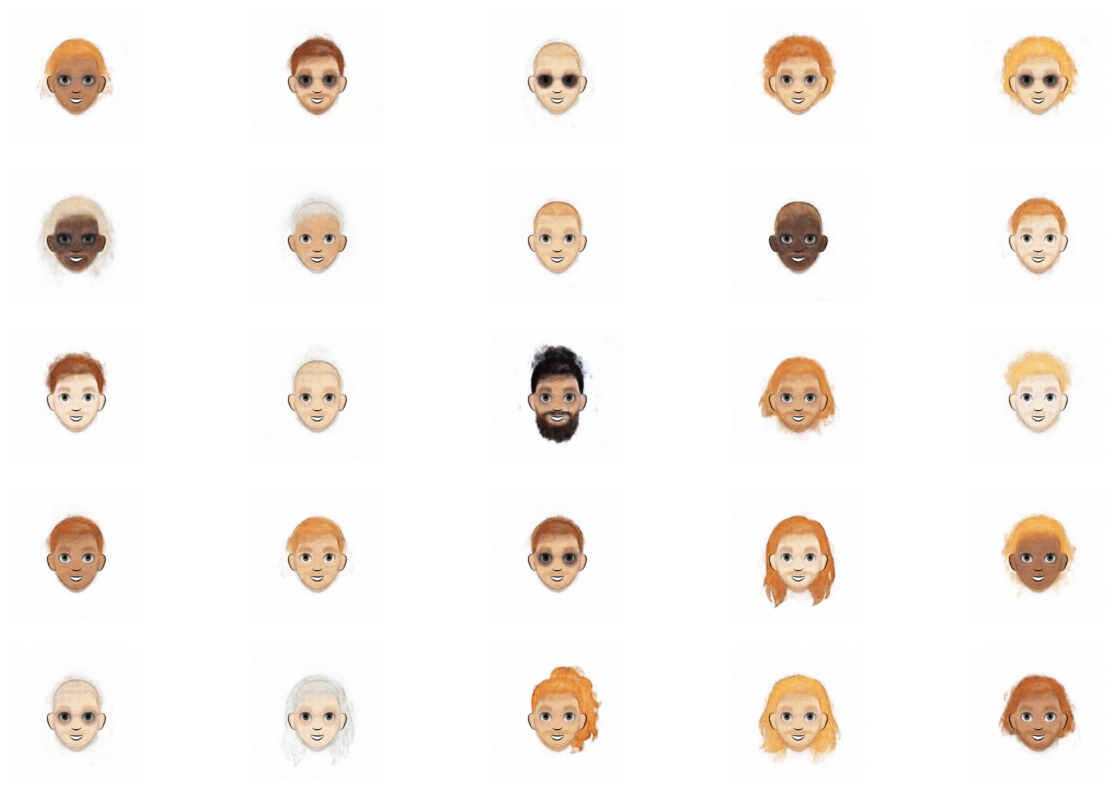

In [45]:
fig = plt.figure(figsize=(15, 10))

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow((np.array(reconstructed_batch[i, :, :, :] * 255)).astype(np.uint8))

### Reconstructing Cartoon Images from a Latent-Vector Sampled with Normal Distribution

1/1 [==============================] - 1s 752ms/step


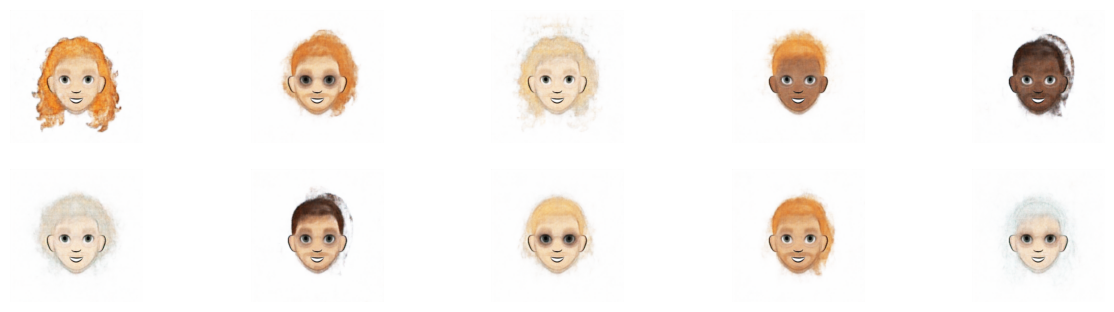

In [46]:
x = np.random.normal(size = (10, 200))  # Show 10 images
reconstructed_images = decoder_model.predict(x)

fig = plt.figure(figsize=(15, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow((np.array(reconstructed_images[i, :, :, :] * 255)).astype(np.uint8))

### Reconstructing Cartoon Images with Latent-Vector Sampled Uniformly

In [52]:
latent_space = np.array(get_generated_image_batch(normalized_train_dataset_part.take(1), model='sampling'))

4/4 [==============================] - 0s 16ms/step


In [53]:
latent_space.shape

(128, 200)

In [56]:
min_x = latent_space.min(axis=0)
max_x = latent_space.max(axis=0)
# print(f'Latent space min. value: {min_x}, max. value: {max_x}')

x = np.random.uniform(size = (10,200))

x = x * (max_x - (np.abs(min_x)))
print(x.shape)

(10, 200)


1/1 [==============================] - 0s 41ms/step


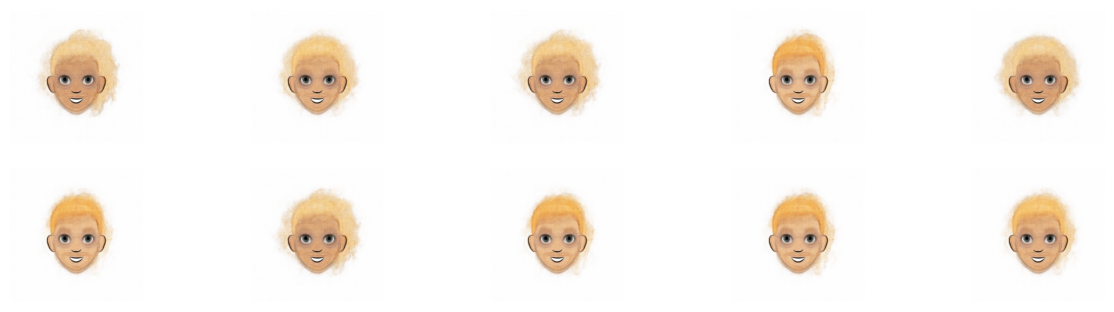

In [58]:
reconstructed_images = decoder_model.predict(x)

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.imshow((np.array(reconstructed_images[i, :, :, :] * 255)).astype(np.uint8))

### Reference

[Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

https://learnopencv.com/variational-autoencoder-in-tensorflow/

https://github.com/spmallick/learnopencv/blob/master/Variational-Autoencoder-TensorFlow/VAE_FashionMnist_TensorFlow.ipynb

https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

https://mbernste.github.io/posts/elbo/

https://abhinavkumarv29.medium.com/elbo-derivation-for-vae-variational-autoencoder-bb048fa1f55e